# Imports

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt

import plotly.graph_objects as go

from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS

import alphashape
import shapely

# Functions

In [2]:
def vis_2d(_df, _x, _y, _color, _algo):
    fig = px.scatter(_df, x=_x, y=_y, color=_color)
    fig.update_layout(title=f'{_algo}: 2D Visualization')
    fig.show()

In [3]:
def anchors_to_contour(anchors_df_, x, y, delta=0.5):
    df_up = anchors_df_.copy()
    df_up[y] = df_up[y] + delta
    df_down = anchors_df_.copy()
    df_down[y] = df_down[y] - delta
    df_right = anchors_df_.copy()
    df_right[x] = df_right[x] + delta
    df_left = anchors_df_.copy()
    df_left[x] = df_left[x] - delta
    return pd.concat([df_up, df_down, df_left, df_right])

In [4]:
def smooth_poly_Chaikins_corner_cutting_iter(poly, iter=1):
    new_poly = poly[:]
    for i in range(iter):
        new_poly = smooth_poly_Chaikins_corner_cutting(new_poly, True)
    return new_poly

def smooth_poly_Chaikins_corner_cutting(poly, append_first_point):
    """
    poly is list of lists
    example: poly1 = [
    [3,3],
    [4,4],
    [5,4],
    [5,7],
    [6,8],
    [7,5],
    [6,3],
    [5,2],
    [4,2],
    [3,3]
    ]
    Based on https://stackoverflow.com/questions/27642237/smoothing-a-2-d-figure
    Q(i) = (3/4)P(i) + (1/4)P(i+1)
    R(i) = (1/4)P(i) + (3/4)P(i+1)
    """
    new_poly = []
    for i in range(len(poly)-1):
        q_i = [0.75 * poly[i][0] + 0.25 * poly[i+1][0], 0.75 * poly[i][1] + 0.25 * poly[i+1][1]]
        r_i = [0.25 * poly[i][0] + 0.75 * poly[i+1][0], 0.25 * poly[i][1] + 0.75 * poly[i+1][1]]
        new_poly.extend([q_i, r_i])
    # append first point for smoothness
    if append_first_point:
        new_poly.append(new_poly[0])
    return new_poly

# Load Data

In [5]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X / 255.
print(X.shape, y.shape)
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

(70000, 784) (70000,)
Size of the dataframe: (70000, 786)


In [6]:
df_sample = df.sample(frac=0.25)

# Anchors Using Affinity Propagation

In [22]:
clustering_centers = []
for label in sorted(df['label'].unique()):
    print(f'Finding anchors of {label}')
    ap = AffinityPropagation().fit(df_sample[df_sample['label']==label][feat_cols].values)
    tmp_df = pd.DataFrame(ap.cluster_centers_,columns=feat_cols)
    tmp_df['label'] = label
    clustering_centers.append(tmp_df)
anchors_df = pd.concat(clustering_centers)

Finding anchors of 0
Finding anchors of 1
Finding anchors of 2
Finding anchors of 3
Finding anchors of 4
Finding anchors of 5
Finding anchors of 6
Finding anchors of 7
Finding anchors of 8
Finding anchors of 9


In [24]:
anchors_df.groupby('label').count()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
label,,,,,,,,,,,,,,,,,,,,,
0,101,101,101,101,101,101,101,101,101,101,...,101,101,101,101,101,101,101,101,101,101
1,89,89,89,89,89,89,89,89,89,89,...,89,89,89,89,89,89,89,89,89,89
2,137,137,137,137,137,137,137,137,137,137,...,137,137,137,137,137,137,137,137,137,137
3,136,136,136,136,136,136,136,136,136,136,...,136,136,136,136,136,136,136,136,136,136
4,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
5,111,111,111,111,111,111,111,111,111,111,...,111,111,111,111,111,111,111,111,111,111
6,120,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
7,128,128,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
8,136,136,136,136,136,136,136,136,136,136,...,136,136,136,136,136,136,136,136,136,136


In [30]:
mds = MDS(n_components=2)
mds_result = mds.fit_transform(anchors_df[feat_cols].values)
anchors_df['mds-one'] = mds_result[:,0]
anchors_df['mds-two'] = mds_result[:,1] 
# df_sample['mds-three'] = mds_result[:,2]

In [31]:
vis_2d(anchors_df, 'mds-one', 'mds-two', 'label', 'MDS')

# Anchors Using Agglomerative Clustering

In [36]:
np.random.seed(31415)
import random
random.seed(9001)

def find_anchors(df_, feat_cols_, label_col, n_clusters):
    # Aggolomerative cluster for each label
    df_ = df_.copy()
    df_['cluster'] = None
    for label in sorted(df_[label_col].unique()):
        print(f'Finding anchors of {label}')
        ag = AgglomerativeClustering(n_clusters=n_clusters)
        df_.loc[df_[label_col]==label, 'cluster'] = ag.fit_predict(df_[df_[label_col]==label][feat_cols_].values)
    
    # Find centroids of clusters to be anchors
    anchors_df_ = df_.groupby([label_col, 'cluster']).mean()
    
    # MDS
    mds = MDS(n_components=2)
    mds_result = mds.fit_transform(anchors_df_[feat_cols_].values)
    anchors_df_['mds-agg-one'] = mds_result[:,0]
    anchors_df_['mds-agg-two'] = mds_result[:,1] 
    anchors_df_.reset_index(inplace=True)
    anchors_df_ = anchors_df_[['mds-agg-one', 'mds-agg-two', label_col]]
    return anchors_df_

DEFAULT_PLOTLY_COLORS=['rgb(31, 119, 180)', 'rgb(255, 127, 14)',
                       'rgb(44, 160, 44)', 'rgb(214, 39, 40)',
                       'rgb(148, 103, 189)', 'rgb(140, 86, 75)',
                       'rgb(227, 119, 194)', 'rgb(127, 127, 127)',
                       'rgb(188, 189, 34)', 'rgb(23, 190, 207)']

def get_concave_hull(points, alpha):
    alpha_shape = alphashape.alphashape(points.tolist(), alpha)
    smooth_shapes = []
    if isinstance(alpha_shape, shapely.geometry.polygon.Polygon):
        alpha_shape = [alpha_shape]
    else: # Multipolygon
        alpha_shape = list(alpha_shape)
    for shape in list(alpha_shape):
        x, y = shape.exterior.coords.xy
        smooth_shape = np.array(smooth_poly_Chaikins_corner_cutting_iter(list(zip(x, y)), 3))
        smooth_shapes.append(smooth_shape)
    return smooth_shapes

def anchors_plot(anchors_agg_df_, x, y, delta, alpha):
    color=iter(DEFAULT_PLOTLY_COLORS)
    contours_df = anchors_to_contour(anchors_agg_df_, x, y, delta)
    fig = go.Figure()
    for label in sorted(anchors_agg_df_['label'].unique()):
        points = contours_df[contours_df['label']==label][[x, y]].values
        concave_hulls = get_concave_hull(points, alpha)
        
        anchors_tmp = anchors_agg_df_[anchors_agg_df_['label']==label][[x, y]].values
        c = next(color)
        fig.add_trace(go.Scatter(x=anchors_tmp[:, 0], y=anchors_tmp[:, 1], 
                                 mode='markers', 
                                 marker_color=c,
                                 name=f'digit_{label}'))
        for concave_hull in concave_hulls:
            fig.add_trace(go.Scatter(x=concave_hull[:, 0], 
                                     y=concave_hull[:, 1], 
                                     fill='toself', 
                                     marker_color=c,
                                     name=f'digit_{label}'))
    fig.show()

        

In [37]:
anchors_df = find_anchors(df_sample, feat_cols, 'label', 5)

Finding anchors of 0
Finding anchors of 1
Finding anchors of 2
Finding anchors of 3
Finding anchors of 4
Finding anchors of 5
Finding anchors of 6
Finding anchors of 7
Finding anchors of 8
Finding anchors of 9


In [38]:
vis_2d(anchors_df, 'mds-agg-one', 'mds-agg-two', 'label', 'MDS')

In [39]:
anchors_plot(anchors_df, 'mds-agg-one', 'mds-agg-two', delta=0.3, alpha=0.5)

In [41]:
df_sample['cluster'] = None
for label in sorted(df['label'].unique()):
    print(f'Finding anchors of {label}')
    ag = AgglomerativeClustering(n_clusters=5)
    df_sample.loc[df_sample['label']==label, 'cluster'] = ag.fit_predict(df_sample[df_sample['label']==label][feat_cols].values)

Finding anchors of 0
Finding anchors of 1
Finding anchors of 2
Finding anchors of 3
Finding anchors of 4
Finding anchors of 5
Finding anchors of 6
Finding anchors of 7
Finding anchors of 8
Finding anchors of 9


In [93]:
anchors_agg_df = df_sample.groupby(['label', 'cluster']).mean()

In [94]:
mds = MDS(n_components=2)
mds_result = mds.fit_transform(anchors_agg_df[feat_cols].values)
anchors_agg_df['mds-agg-one'] = mds_result[:,0]
anchors_agg_df['mds-agg-two'] = mds_result[:,1] 
anchors_agg_df.reset_index(inplace=True)
anchors_agg_df = anchors_agg_df[['mds-agg-one', 'mds-agg-two', 'label']]

In [95]:
vis_2d(anchors_agg_df, 'mds-agg-one', 'mds-agg-two', 'label', 'MDS')

In [164]:
anchors_plot(anchors_agg_df, 'mds-agg-one', 'mds-agg-two', delta=0.3, alpha=0.5)

In [96]:
contours_df = anchors_to_contour(anchors_agg_df, 'mds-agg-one', 'mds-agg-two', 0.3)

In [97]:
vis_2d(contours_df, 'mds-agg-one', 'mds-agg-two', 'label', 'MDS')

In [98]:
points_0 = contours_df[contours_df['label']=='0'][['mds-agg-one', 'mds-agg-two']].values

In [99]:
points_0

array([[ 5.1623443 , -3.9080139 ],
       [-6.19270409, -1.50115411],
       [ 5.79490275,  0.46660858],
       [ 5.95430809, -1.77425663],
       [-4.13999106, -0.89133936],
       [ 5.1623443 , -4.5080139 ],
       [-6.19270409, -2.10115411],
       [ 5.79490275, -0.13339142],
       [ 5.95430809, -2.37425663],
       [-4.13999106, -1.49133936],
       [ 4.8623443 , -4.2080139 ],
       [-6.49270409, -1.80115411],
       [ 5.49490275,  0.16660858],
       [ 5.65430809, -2.07425663],
       [-4.43999106, -1.19133936],
       [ 5.4623443 , -4.2080139 ],
       [-5.89270409, -1.80115411],
       [ 6.09490275,  0.16660858],
       [ 6.25430809, -2.07425663],
       [-3.83999106, -1.19133936]])

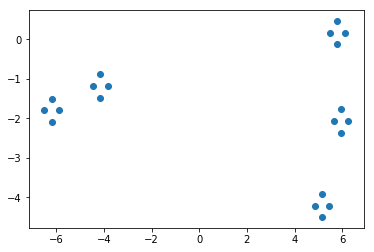

In [100]:
fig, ax = plt.subplots()
ax.scatter(*zip(*points_0))
plt.show()

In [135]:
alpha_shape = alphashape.alphashape(points_0.tolist(), 0.2)

In [136]:
list(alpha_shape)

In [132]:
x, y = alpha_shape.exterior.coords.xy

AttributeError: 'MultiPolygon' object has no attribute 'exterior'

In [130]:
fig = go.Figure()
anchors_tmp = anchors_agg_df[anchors_agg_df['label']=='0'][['mds-agg-one', 'mds-agg-two']].values
fig.add_trace(go.Scatter(x=smooth_poly[:, 0], y=smooth_poly[:, 1], fill='toself'))
fig.add_trace(go.Scatter(x=anchors_tmp[:, 0], y=anchors_tmp[:, 1], mode='markers'))
fig.show()

In [124]:
#smooth
smooth_poly = np.array(smooth_poly_Chaikins_corner_cutting_iter(list(zip(x, y)), 3))
fig = go.Figure(go.Scatter(x=smooth_poly[:, 0], y=smooth_poly[:, 1], fill="toself"))
fig.show()

In [117]:
fig = go.Figure(go.Scatter(x=np.array(x), y=np.array(y), fill="toself"))
fig.show()

In [116]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.array(x), y=np.array(y),
                    fill='toself', fillcolor='darkviolet',
                    hoveron = 'fills', # select where hover is active
                    line_color='darkviolet'))

fig.show()

In [102]:
print(alpha_shape)

POLYGON ((5.162344296878053 -4.508013902728372, -6.192704087247921 -2.101154114934547, -6.492704087247921 -1.801154114934547, -6.192704087247921 -1.501154114934547, -4.139991056024437 -0.8913393592226655, 5.794902749748486 0.4666085837810442, 6.094902749748486 0.1666085837810442, 6.254308094725114 -2.074256630016429, 5.462344296878053 -4.208013902728372, 5.162344296878053 -4.508013902728372))


In [67]:
fig, ax = plt.subplots()
ax.scatter(*zip(*points_0))
ax.add_patch(PolygonPatch(alpha_shape, alpha=0.2))
plt.show()